# Machine learning on rides of 2017

In [1]:
_FTP_ = 225
_PATH_ = '/home/caster/training_data'

# Preparation and function definitions

In [2]:
%run -i training_functions.py

# Read power data generating a dataframe called 't_data'

In [3]:
t_data = read_intervals(_PATH_, _FTP_)

t_data[:10].drop(['watts_std', 'watts_25', 'watts_50', 'watts_75', 'watts_max', 'temp', 'hr_max'], axis=1)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in double_scalars


,filename,epoch_day,time,cad,hr,hr_min,hr_drift,km,kph,kilojoules,watts,np,alt,vi,tss,if,training_type
0,2017_02_18_11_13_04.utf8.json,17215,118,62.952481,151.204584,104,-0.233592,51.11070,25.871660,1064.2005,149.173045,227.744560,443.6,1.526714,152.671389,1.012198,Endurance
0,2017_02_22_17_33_49.utf8.json,17219,67,NaN,131.801924,90,NaN,24.28590,21.456039,NaN,NaN,NaN,390.6,NaN,NaN,NaN,NA
0,2017_03_07_17_47_18.utf8.json,17232,10,62.576433,137.426752,114,0.339606,4.69625,26.520306,93.3940,148.716561,216.195434,67.2,1.453741,0.000000,0.960869,Endurance
0,2017_03_07_17_47_18.utf8.json,17232,23,86.882497,171.672943,147,0.129740,18.93060,35.632825,310.9230,216.822176,234.398718,86,1.081064,0.000000,1.041772,FTP
0,2017_03_07_17_47_18.utf8.json,17232,46,71.348523,155.900576,126,-0.014478,37.26620,23.778161,400.1225,144.136347,235.856360,188.2,1.636342,0.000000,1.048250,Endurance
0,2017_03_10_17_46_57.utf8.json,17235,4,61.197761,138.582090,118,0.002620,0.91421,12.047118,42.8330,159.824627,221.239447,39.6,1.384264,0.000000,0.983286,Endurance
0,2017_03_10_17_46_57.utf8.json,17235,26,61.663425,145.644605,115,0.082763,23.27900,30.088589,174.7355,109.620765,186.888240,72.6,1.704862,0.000000,0.830614,Active recovery
0,2017_03_10_17_46_57.utf8.json,17235,20,80.738372,174.304817,138,0.146455,9.96009,26.927528,269.7650,224.057309,236.577337,158.6,1.055879,0.000000,1.051455,FTP
0,2017_03_11_17_34_54.utf8.json,17236,87,68.018194,135.779672,102,-0.012015,34.94850,23.891792,749.9425,142.873404,181.344455,501.2,1.269267,126.926670,0.805975,Endurance
0,2017_03_17_18_00_29.utf8.json,17242,16,81.361111,175.579293,157,0.178841,25.67930,38.147976,232.4320,234.779798,257.933357,39.6,1.098618,0.000000,1.146370,FTP


# Linear regression HR with Power data (using Keras)

In [4]:
from sklearn.preprocessing import StandardScaler

import keras
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt

def linear_regression(cur, x_values, y_values):

    x_ = cur[x_values]
    y_ = cur[y_values]

#     x = x_
    x = sc.fit_transform(x_.values.reshape(-1, 1))
    y = y_

    # Model
    inputs = Input(shape=(1,))
    preds = Dense(1, activation='linear')(inputs)

    model = Model(inputs=inputs,outputs=preds)
    sgd = keras.optimizers.SGD()

    model.compile(optimizer=sgd ,loss='mse',metrics=['mse'])
    model.fit(x,y, batch_size=1, epochs=30, shuffle=False, verbose=0)

    # Plot
    plt.figure(figsize=(15, 6), dpi=80)
    plt.scatter(x_,y, color='blue', linewidths=10)

    plt.xlabel(x_values)
    plt.ylabel(y_values)

    plt.plot(x_, model.predict(x), color='red', linewidth=1)

    plt.show()

    slope = model.get_weights()[0].item(0)
    interceptor = model.get_weights()[1].item(0)

    print("Slope:       %f" % slope)
    print("Interceptor: %f" % interceptor)
    
    return model


Using TensorFlow backend.


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


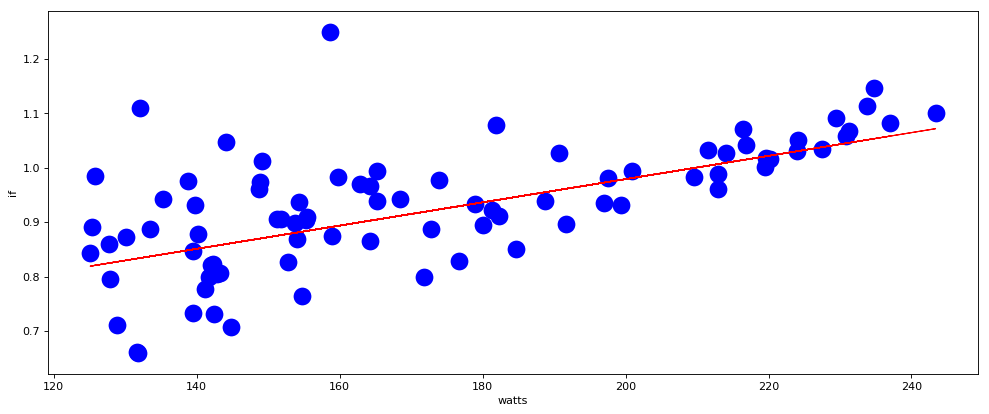

Slope:       0.073349
Interceptor: 0.919888


In [10]:
# Normalize
sc = StandardScaler()
cur = t_data[t_data['training_type'] != 'Active recovery']
cur.dropna(inplace=True)

model = linear_regression(
    cur.drop(['filename', 'epoch_day', 'kph', 'temp', 'alt', 'km'], axis=1), 
    'watts', 
    'if')

In [11]:
prediction = 230.0

norm_hr = sc.transform(np.array([prediction]).reshape(-1, 1))
a = model.predict(norm_hr).item(0)

print("Predicting when X = %f -> Y = %f if" % (prediction, a))

Predicting when X = 230.000000 -> Y = 1.043408 if


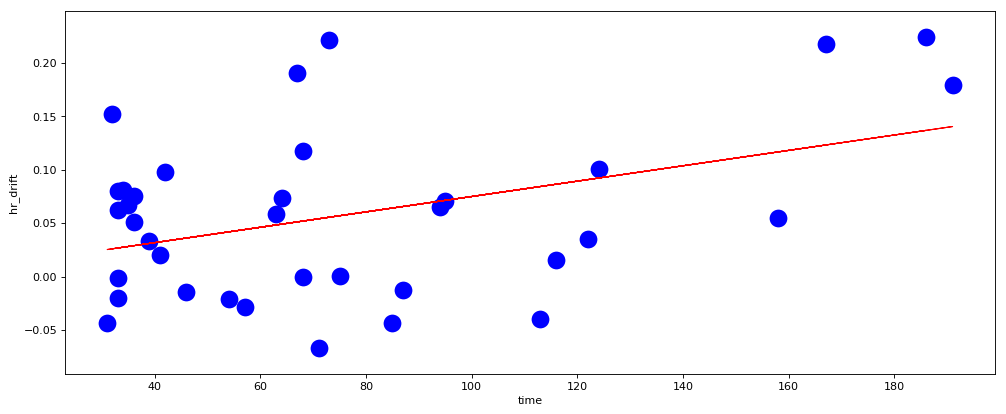

Slope:       0.032308
Interceptor: 0.057182


In [18]:
sc = StandardScaler()
cur = t_data[t_data['training_type'] != 'Active Recovery']
cur = cur.dropna()
cur = cur[cur['time'] > 30]
cur = cur[(cur.hr_drift > cur.hr_drift.quantile(0.05)) & (cur.hr_drift < cur.hr_drift.quantile(0.95))]

model = linear_regression(
    cur.drop(['filename', 'epoch_day', 'kph', 'temp', 'alt', 'km'], axis=1), 
    'time', 
    'hr_drift')

In [19]:
prediction = 80.0

norm_hr = sc.transform(np.array([prediction]).reshape(-1, 1))
a = model.predict(norm_hr).item(0)

print("Predicting when X = %f -> Y = %f" % (prediction, a))

Predicting when X = 80.000000 -> Y = 0.060738
